In [30]:
import keras
from keras import layers
from keras import ops
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import tensorflowjs as tfjs

os.environ["KERAS_BACKEND"] = "tensorflow"

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train/255

5

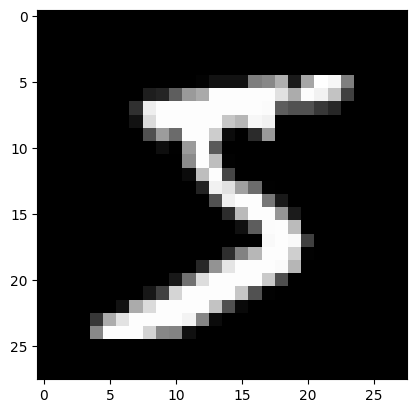

In [6]:
plt.imshow(x_train[0], cmap="gray")
y_train[0]

In [21]:
class Sampler(layers.Layer):
    def __init__(self, latent_dim=2, **kwargs):
        super().__init__(**kwargs)
        self.enc_mu = layers.Dense(latent_dim)
        self.enc_log_var = layers.Dense(latent_dim)
    
    def call(self, x):
        mean = self.enc_mu(x)
        log_var = self.enc_log_var(x)
        stddev = ops.exp(0.5*log_var)

        batch = ops.shape(mean)[0]
        dim = ops.shape(mean)[1]
        eps = keras.random.normal(shape=(batch, dim))
        z = mean + eps*stddev

        return z, mean, log_var

class VAE(keras.Model):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.encoder = keras.Sequential([
            layers.Input(shape=(784,)),
            layers.Dense(128, activation="relu")
        ])
        self.sampler = Sampler(latent_dim)
        self.decoder = keras.Sequential([
            layers.Dense(128, activation="relu"),
            layers.Dense(784, activation="sigmoid")
        ])

    def call(self, x):
        x = self.encoder(x)
        z, z_mean, z_log_var = self.sampler(x)
        recon = self.decoder(z)
        
        return recon, z, z_mean, z_log_var

class Trainer(keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.flatten = layers.Flatten(input_shape=(28, 28, 1))
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_term_tracker = keras.metrics.Mean(name="kl_term")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    
    @property
    def metrics(self):
        return [self.reconstruction_loss_tracker, self.kl_term_tracker, self.total_loss_tracker]
    
    def train_step(self, data):
        # forward
        with tf.GradientTape() as tape:
            x = self.flatten(data)
            x_hat, _, mean, log_var = self.model(x)
            kl_term = -0.5*(ops.sum(1 + log_var - mean**2 - ops.exp(log_var), axis=-1))
            recon = ops.sum((x-x_hat)**2, axis=-1)
            loss = ops.mean(recon) + ops.mean(kl_term)
            
        # learn
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update metrics to show during training
        self.reconstruction_loss_tracker.update_state(recon)
        self.kl_term_tracker.update_state(kl_term)
        self.total_loss_tracker.update_state(loss)
        return {
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_term": self.kl_term_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }


ae = VAE(latent_dim=2)
t = Trainer(ae)
t.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))
t.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_term: 7.2525 - reconstruction_loss: 69.7727 - total_loss: 77.0252
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_term: 2.8170 - reconstruction_loss: 43.1309 - total_loss: 45.9479
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_term: 2.9880 - reconstruction_loss: 41.0001 - total_loss: 43.9881
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_term: 3.1427 - reconstruction_loss: 39.8317 - total_loss: 42.9744
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_term: 3.2646 - reconstruction_loss: 39.1435 - total_loss: 42.4080
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_term: 3.3616 - reconstruction_loss: 38.7870 - total_loss: 42.1486
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_term: 3.4531 - reconstruction_loss: 38.4074 - total_loss: 41.8605
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_term: 3.5356 - reconstruction_loss: 37.9145 - total_loss: 41.4501
Epoch 9/10
469/4

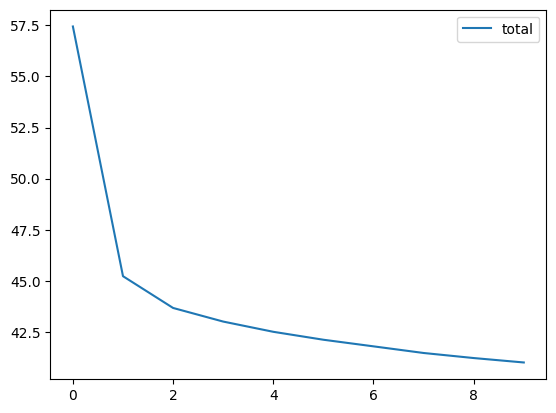

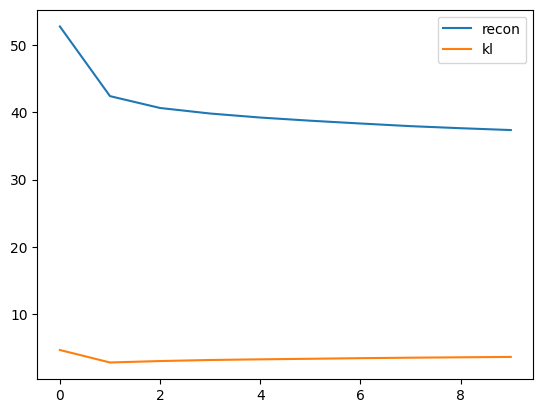

In [10]:
plt.plot(t.history.history["total_loss"], label="total")
plt.legend()
plt.show()
plt.plot(t.history.history["reconstruction_loss"], label="recon")
plt.plot(t.history.history["kl_term"], label="kl")
plt.legend()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


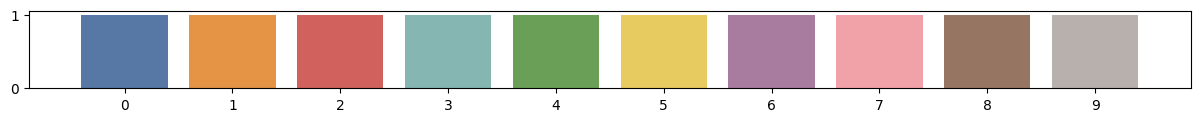

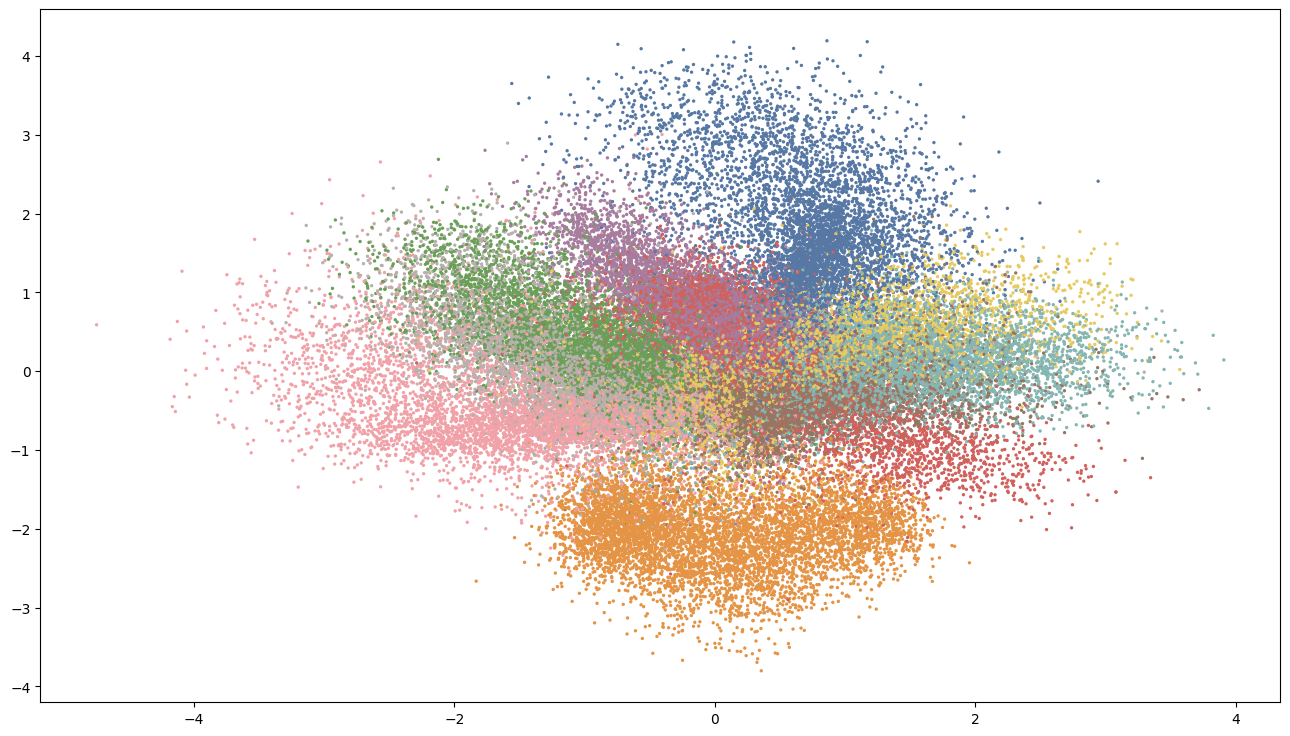

In [11]:
# now visualize the embedding space
def compute_embeddings(model, x_train, y_train):
	_, latents, _, _ = model.predict(x_train.reshape(-1, 784))
	return latents, y_train

def custom_legend(colors, labels):
	fig, ax = plt.subplots()
	fig.set_figwidth(15)
	fig.set_figheight(1)
	ax.bar(labels, [1 for i in range(len(labels))], label=labels, color=colors)
	return ax

def plot_mnist(latents, labels):
	tab10 = ["#5778a4", "#e49444", "#d1615d", "#85b6b2", "#6a9f58", "#e7ca60", "#a87c9f", "#f1a2a9", "#967662", "#b8b0ac"]
	custom_legend(tab10, [str(i) for i in range(10)])
	plt.show()
	plt.figure(figsize=(16, 9))
	plt.scatter(latents[:, 0], latents[:, 1], c=[tab10[i] for i in labels.tolist()], s=2, alpha=1)

latents, labels = compute_embeddings(ae, x_train, y_train)
plot_mnist(latents, labels)

In [31]:
tf.saved_model.save(ae.encoder, "models/encoder")
tf.saved_model.save(ae.decoder, "models/decoder")
tfjs.converters.convert_tf_saved_model("models/encoder", "models/tfjs/encoder")
tfjs.converters.convert_tf_saved_model("models/decoder", "models/tfjs/decoder")

INFO:tensorflow:Assets written to: models/encoder/assets


INFO:tensorflow:Assets written to: models/encoder/assets


INFO:tensorflow:Assets written to: models/decoder/assets


INFO:tensorflow:Assets written to: models/decoder/assets
2024-09-02 16:57:13.765600: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-09-02 16:57:13.884151: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
